# Performance Comparison of Dimension Reduction Implementations

Different dimension reduction techniques can have quite different computational complexity. Beyond the algorithm itself there is also the question of how exactly it is implemented. These two factors can have a significant role in how long it actually takes to run a given dimension reduction. Furthermore the nature of the data you are trying to reduce can also matter -- mostly the involves the dimensionality of the original data. Here we will take a brief look at the performance characterstics of a number of dimension reduction implementations.

To start let's get the basic tools we'll need loaded up -- numpy and pandas obviously, but also tools to get and resample the data, and the time module so we can perform some basic benchmarking.

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_mldata
from sklearn.utils import resample
import time

Next we'll need the actual dimension reduction implementations. For the purposes of this explanation we'll mostly stick with [scikit-learn](http://scikit-learn.org/stable/), but for the sake of comparison we'll also include the [MulticoreTSNE](https://github.com/DmitryUlyanov/Multicore-TSNE) implementation of t-SNE, which has significantly better performance than the current scikit-learn t-SNE.

In [2]:
from sklearn.manifold import TSNE, LocallyLinearEmbedding, Isomap, MDS, SpectralEmbedding
from sklearn.decomposition import PCA
from MulticoreTSNE import MulticoreTSNE
from umap import UMAP

Next we'll need out plotting tools, and, of course, some data to work with. For this performance comparison we'll default to the now standard benchmark of manifold learning: the MNIST digits dataset. We can use scikit-learn's ``fetch_mldata`` to grab it for us.

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
sns.set(context='notebook', 
        rc={'figure.figsize':(12,10)},
        palette=sns.color_palette('tab10', 10))

In [5]:
mnist = fetch_mldata('MNIST Original')

Now it is time to start looking at performance. To start with let's look at how performance scales with increasing dataset size.

## Performance scaling by dataset size

As the size of a dataset increases the runtime of a given dimension reduction algorithm will increase at varying rates. If you ever want to run your algorithm on larger datasets you will care not just about the comparative runtime on a single small dataset, but how the performance scales out as you move to larger datasets. We can similate this by subsampling from MNIST digits (via scikit-learn's convenient ``resample`` utility) and looking at the runtime for varying sized subsamples. Since there is some randomness involved here (both in the subsample selection, and in some of the algorithms which have stochastic aspects) we will want to run a few examples for each dataset size. We can easily package all of this up in a simple function that will return a convenient pandas dataframe of dataset sizes and runtimes given an algorithm.

In [6]:
def data_size_scaling(algorithm, data, sizes=[100, 200, 400, 800, 1600], n_runs=5):
    result = []
    for size in sizes:
        for run in range(n_runs):
            subsample = resample(data, n_samples=size)
            start_time = time.time()
            algorithm.fit(subsample)
            elapsed_time = time.time() - start_time
            del subsample
            result.append((size, elapsed_time))
    return pd.DataFrame(result, columns=('dataset size', 'runtime (s)'))

Now we just want to run this for each of the various dimension reduction implementations so we can look at the results. Since we don't know how long these runs might take we'll start off with a very small set of samples, scaling up to only 1600 samples.

In [7]:
all_algorithms = [
    PCA(),
    UMAP(),
    MulticoreTSNE(),
    LocallyLinearEmbedding(),
    SpectralEmbedding(), 
    Isomap(), 
    TSNE(),
    MDS(),
]
performance_data = {}
for algorithm in all_algorithms:
    alg_name = str(algorithm)
    if 'MulticoreTSNE' in alg_name:
        alg_name = 'MulticoreTSNE'
    else:
        alg_name = alg_name.split('(')[0]
        
    performance_data[alg_name] = data_size_scaling(algorithm, mnist.data, n_runs=3)

/opt/anaconda3/envs/umap_dev/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/opt/anaconda3/envs/umap_dev/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/opt/anaconda3/envs/umap_dev/lib/python3.6/site-packages/sklearn/neighbors/base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


Now let's plot the results so we can see what is going on. We'll use seaborn's regression plot to interpolate the effective scaling.

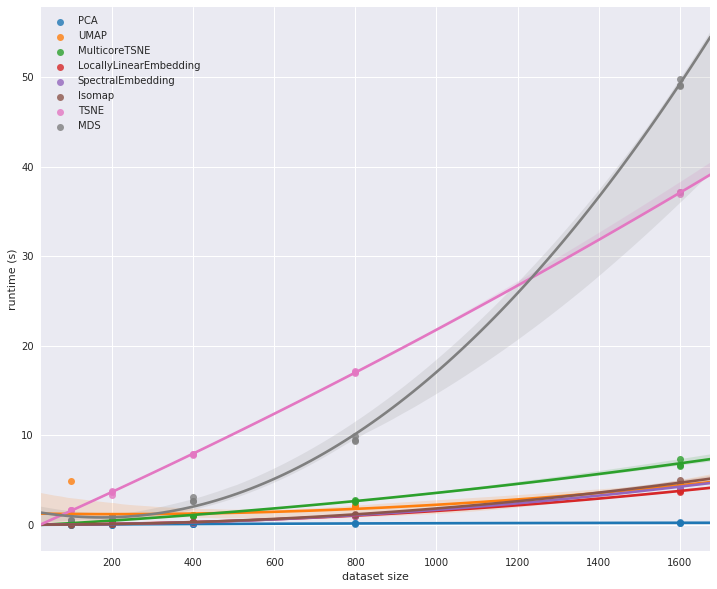

In [8]:
for alg_name, perf_data in performance_data.items():
    sns.regplot('dataset size', 'runtime (s)', perf_data, order=2, label=alg_name)
plt.legend()

We can see straight away that there are some outliers here. The scikit-learn t-SNE is clearly much slower than most of the other algorithms. It does not have the scaling properties of MDS however; for larger dataset sizes MDS is going to quickly become completely unmanageable. At the same time MulticoreTSNE demonstrates that t-SNE can run fairly efficiently. It is hard to tell much about the other implementations other than the fact that PCA is far and away the fastest option. To see more we'll have to look at runtimes on larger dataset sizes. Both MDS and scikit-learn's t-SNE are going to take too long to run so let's restrict ourselves to the fastest performing implementations and see what happens as we extend out to larger dataset sizes.

In [9]:
fast_algorithms = [
    PCA(),
    UMAP(),
    MulticoreTSNE(),
    LocallyLinearEmbedding(),
    SpectralEmbedding(),
    Isomap(),
]
fast_performance_data = {}
for algorithm in fast_algorithms:
    alg_name = str(algorithm)
    if 'MulticoreTSNE' in alg_name:
        alg_name = 'MulticoreTSNE'
    else:
        alg_name = alg_name.split('(')[0]
        
    fast_performance_data[alg_name] = data_size_scaling(algorithm, mnist.data, 
                                                   sizes=[800, 1600, 3200, 6400, 12800], n_runs=3)

/opt/anaconda3/envs/umap_dev/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


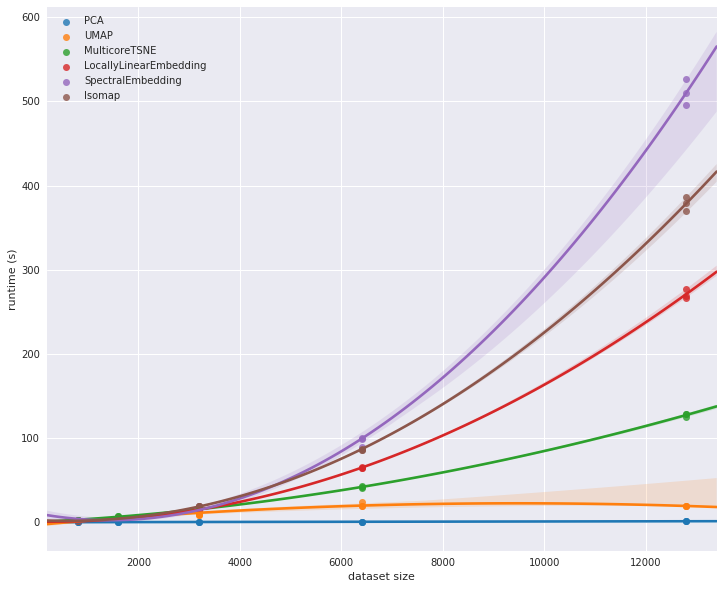

In [10]:
for alg_name, perf_data in fast_performance_data.items():
    sns.regplot('dataset size', 'runtime (s)', perf_data, order=2, label=alg_name)
plt.legend()

At this point we begin to see some significant differentiation among the different implementations. In the earlier plot MulticoreTSNE looked to be slower than some of the other algorithms, but as we scale out to larger datasets we see that its relative scaling performance is far superior to the scikit-learn implementations of Isomap, spectral embedding, and locally linear embedding.

It is probably worth extending out further -- up to the full MNIST digits dataset. To manage to do that in any reasonable amount of time we'll have to restrict out attention to an even smaller subset of implementations. We will pare things down to just MulticoreTSNE, PCA and UMAP.

In [11]:
very_fast_algorithms = [
    PCA(),
    UMAP(),
    MulticoreTSNE(),
]
vfast_performance_data = {}
for algorithm in very_fast_algorithms:
    alg_name = str(algorithm)
    if 'MulticoreTSNE' in alg_name:
        alg_name = 'MulticoreTSNE'
    else:
        alg_name = alg_name.split('(')[0]
        
    vfast_performance_data[alg_name] = data_size_scaling(algorithm, mnist.data, 
                                                    sizes=[3200, 6400, 12800, 25600, 51200, 70000], n_runs=2)

/opt/anaconda3/envs/umap_dev/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/opt/anaconda3/envs/umap_dev/lib/python3.6/site-packages/umap_learn-0.3.0-py3.6.egg/umap/spectral.py:188: UserWarning: Embedding 3 connected components using meta-embedding (experimental)
/opt/anaconda3/envs/umap_dev/lib/python3.6/site-packages/umap_learn-0.3.0-py3.6.egg/umap/spectral.py:188: UserWarning: Embedding 2 connected components using meta-embedding (experimental)
/opt/anaconda3/envs/umap_dev/lib/python3.6/site-packages/umap_learn-0.3.0-py3.6.egg/umap/spectral.py:188: UserWarning: Embedding 2 connected components using meta-embedding (experimental)
/opt/anaconda3/envs/umap_dev/lib/python3.6/site-packages/umap_learn-0.3.0-py3.6.egg/umap/spectral.py:188: UserWarning: Embedding 3 connected components using meta-embedding (experimental)


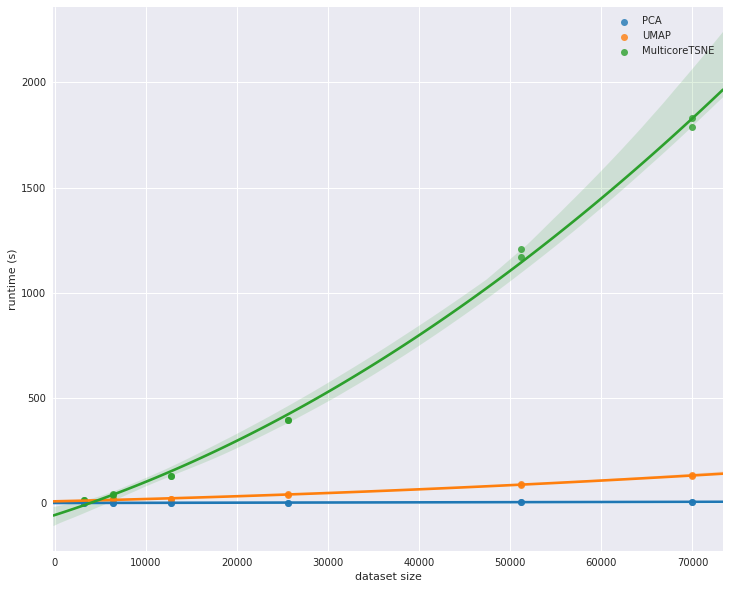

In [12]:
for alg_name, perf_data in vfast_performance_data.items():
    sns.regplot('dataset size', 'runtime (s)', perf_data, order=2, label=alg_name)
plt.legend()

Here we see UMAP's advantages over t-SNE really coming to the forefront. While UMAP is clearly slower than PCA, its scaling performance is dramatically better than MulticoreTSNE, and for even larger datasets the difference is only going to grow.

This concludes our look at scaling by dataset size. The short summary is that PCA is far and away the fastest option, but you are potentially giving up a lot for that speed. UMAP, while not competitive with PCA, is clearly the next best option in terms of performance among the implementations explored here. Given the quality of results that UMAP can provide we feel it is clearly a good option for dimension reduction.